# **Steam 플렛폼 구매율 예측 (linear regression)**

<img src = 'http://images.vg247.com/current//2011/04/steam1.jpg'>

# **개요**

## **목표**
스팀 플렛폼(게임)에 관련된 데이터로 <span style="color:red">구매율(어플리케이션 소유자 수)</span>를 예측하는 모델을 생성<br>
<br>

## **변수정의**

  * appid - 게임 고유 ID
  * name - 게임 이름
  * developer - 개발자(여러 개발자 일 경우 쉼표로 구분)
  * publisher - 발행자(유통사)
  * score_rank - 사용자 리뷰를 기반으로 만들어진 게임의 점수 등급
  * positive - 긍정적인 사용자의 리뷰 수
  * negative - 부정적인 사용자의 리뷰 수
  * userscore - 게임 사용자들이 평가한 점수
  * <span style="color:red">owners - steam에서 해당 어플리케이션 소유자 수</span>
  * owners_variance - 소유자 분산(변동,차이). (실제소유자 +/- 변동범위) 형태로 표기
  * players_forever - 2009년 3월 이후로 플레어 수
  * players_forever_variance - 전체 플레이어의 분산. (전체 플레이어 +/- 변동범위) 형태로 표기
  * players_2weeks - 지난 2 주 동안 플레이어들의 수
  * players_2weeks_variance - 지난 2 주 동안 플레이어의 수에 대한 분산 (플레이어 수 +/- 변동범위) 형태로 표기
  * average_forever - 2009년 3월 이후 플레이 시간(평균). 분 단위.
  * average_2weeks - 지난 2 주간 플레이 시간(평균). 분 단위.
  * median_forever - 2009년 3월 이후 플레이 시간(중앙값). 분 단위.
  * median_2weeks - 지난 2 주간 플레이 시간(중앙값). 분 단위. 
  * price - US가격. 센트 단위.
  * ccu - 어제 최고 CCU(개별 앱이 요청된 경우에만 카운트) **
  * tag_(tag name) - 해당 게임의 태그(Yes=1, No=0)
  * genre_(genre name) - 해당 게임의 장르(Yes=1, No=0)

## **데이터**
Train 데이터 :<br>
    * 구매율 상위 200위 미만 데이터
Test 데이터 :<br>
    * 구매율 상위 200위 이상 데이터

In [19]:
import pymysql
import pandas as pd
import matplotlib.pylab as plt

## **1. 데이터로딩**
MySQL to Jupyter notebook

In [20]:
host_name = "127.0.0.1"
username = "root"
password = ""
database_name = "steam_test"

In [21]:
db = pymysql.connect(
    host = host_name,
    port=3306,
    user=username,
    passwd=password,
    db=database_name,
    charset='utf8'
)

In [22]:
# 변수명
c_name = """
SELECT COLUMN_NAME
FROM information_schema.columns 
WHERE 
    table_schema = 'steam_test' 
    AND 
    table_name = 'merge_steam';
"""
column_name = pd.read_sql(c_name, db)
# tag range 20 ~ 362
# genre range 363 ~ 387
column_name

,COLUMN_NAME
0,appid
1,name
2,owners
3,owners_variance
4,negative
5,positive
6,score_rank
7,ccu
8,players_2weeks
9,players_forever_variance


In [23]:
# 마지막 row
last_row ="""
SELECT * FROM merge_steam ORDER BY appid DESC LIMIT 1
"""
sql_1 = pd.read_sql(last_row, db)
sql_1

,appid,name,owners,owners_variance,negative,positive,score_rank,ccu,players_2weeks,players_forever_variance,...,genre_Sports,genre_Early_Access,genre_Utilities,genre_Audio_Production,genre_Design_and_Illustration,genre_Web_Publishing,genre_Photo_Editing,genre_Education,genre_Software_Training,genre_Accounting
0,779310,Red and Yellow,1558,1243,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# train 데이터
train_select ="""
SELECT * FROM merge_steam;
"""
train_data = pd.read_sql(train_select, db)
train_data.describe()

# # test 데이터
# test_select ="""

# """
# test_data = pd.read_sql(test_select, db)


,appid,owners,owners_variance,negative,positive,score_rank,ccu,players_2weeks,players_forever_variance,players_2weeks_variance,...,genre_Sports,genre_Early_Access,genre_Utilities,genre_Audio_Production,genre_Design_and_Illustration,genre_Web_Publishing,genre_Photo_Editing,genre_Education,genre_Software_Training,genre_Accounting
count,16722.000000,1.672200e+04,16722.000000,16722.000000,1.672200e+04,16722.000000,1.672200e+04,1.672200e+04,16722.000000,16722.000000,...,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0,16722.0
mean,415098.262349,1.892723e+05,7757.778914,262.853068,1.331848e+03,37.351872,3.778284e+02,7.838098e+03,5888.402823,1152.652912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,185222.142966,1.317502e+06,11154.753854,3299.447117,1.984100e+04,31.439877,2.383492e+04,1.944500e+05,9346.944267,2605.644763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,10.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,303595.000000,3.634000e+03,1966.000000,3.000000,1.200000e+01,8.000000,0.000000e+00,0.000000e+00,1520.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,416235.000000,1.557600e+04,3933.000000,17.000000,4.800000e+01,31.000000,0.000000e+00,7.670000e+02,2734.000000,879.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,551912.500000,8.514800e+04,9196.000000,77.000000,2.447500e+02,61.000000,4.000000e+00,1.298000e+03,6659.000000,1523.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,779310.000000,1.204637e+08,301009.000000,245704.000000,2.162074e+06,100.000000,2.971824e+06,2.011675e+07,301009.000000,138470.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


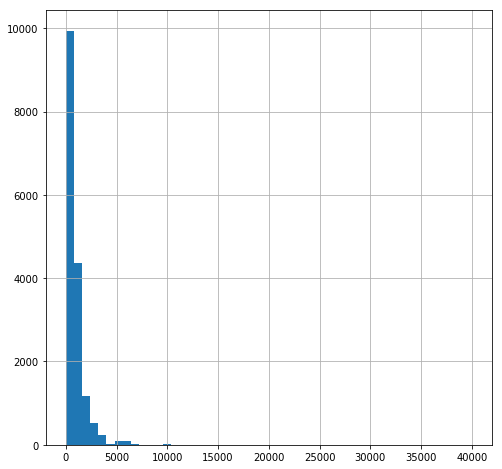

In [67]:
# (단위 999 = 9.99 US Dollar편의상 USD로 표기) 대부분의 가격이 50 USD이하 에 편향 되어 있다.
all_data['price'].hist(bins=50,figsize=(8,8))
plt.show()

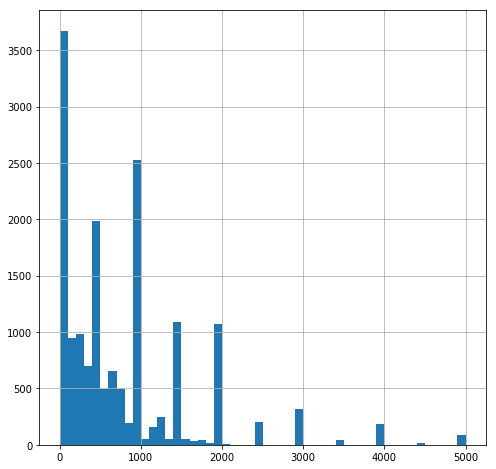

In [63]:
# (free ~ 40.00USD) 
all_data['price'].hist(bins=50, range=[0, 5000], figsize=(8,8))
plt.show()

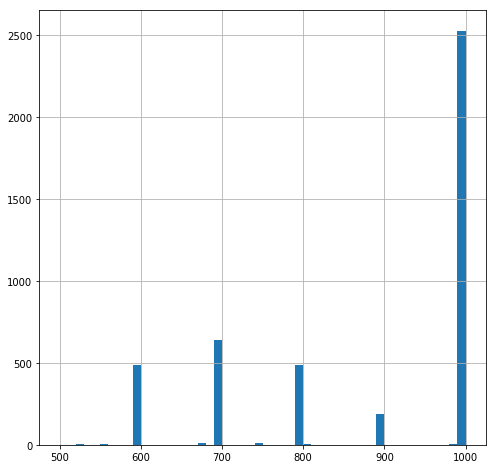

In [66]:
# (5.00 ~ 10.00 USD) 세부적으로 살펴보면 가격은 정수값에 -0.01 값이 연산된 가격이 주를 이루고 있다.
all_data['price'].hist(bins=50, range=[500, 1000], figsize=(8,8), histtype=('bar'))
plt.show()